In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import cv2
from scipy import optimize

base_dir = '/home/aquiles/Data/Dispertech/Data/2020-02-28'

In [3]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

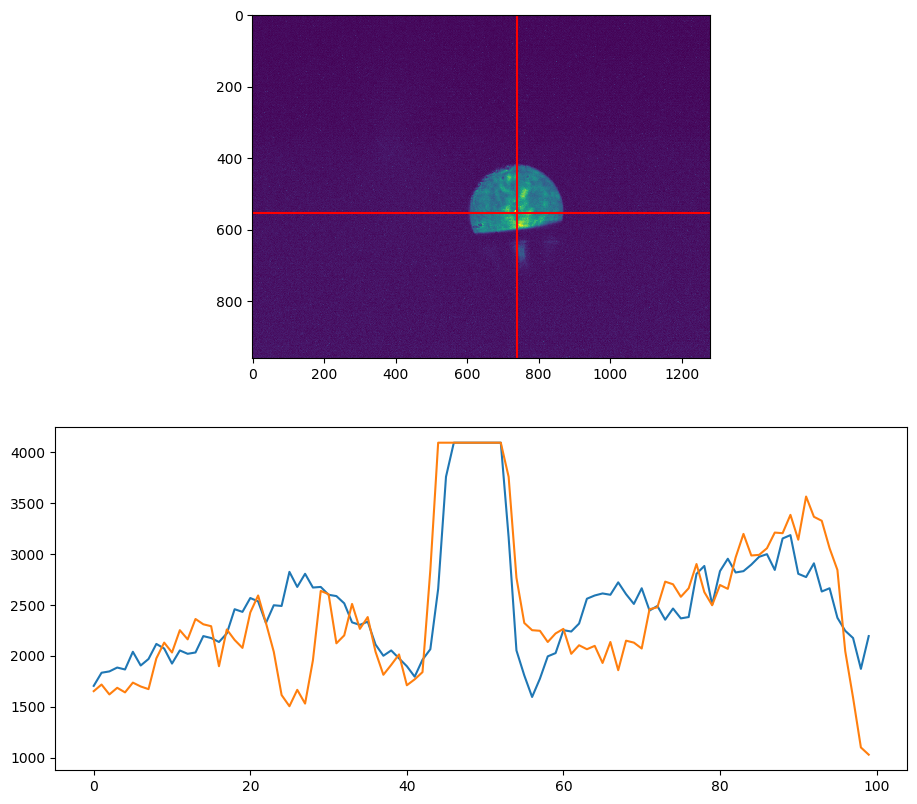

In [4]:
file = "fiber_end_1902019_0.npy"
filename = os.path.join(base_dir,file)
data = np.load(os.path.join(base_dir, filename))
fig, ax = plt.subplots(2, figsize=(11,10), dpi=100)
fig.set()
y = 553
x = 739
ax[0].imshow(data.T)
ax[0].axhline(y=y,color='red')
ax[0].axvline(x=x,color='red')
ax[1].plot(data[x-50:x+50,y])
ax[1].plot(data[x,y-50:y+50])

14.694692552774422 14.389423671965314


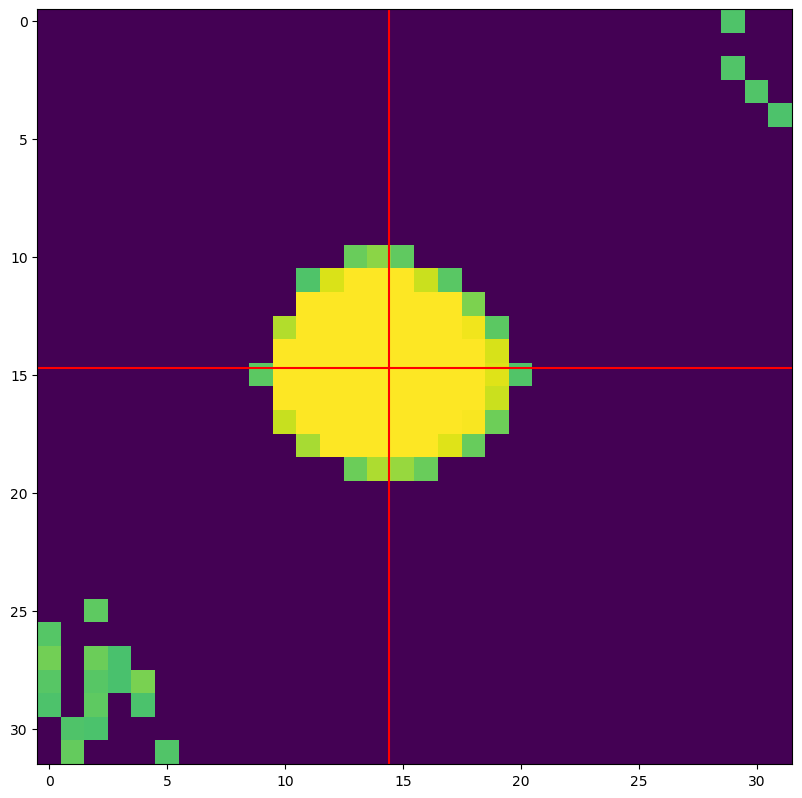

In [8]:
cropped_data = np.copy(data[x-15:x+15, y-15:y+15])
cropped_data[cropped_data<np.mean(cropped_data)+np.std(cropped_data)] = 0
p = fitgaussian(cropped_data)
print(p[1], p[2])
fig, ax = plt.subplots(1, figsize=(11,10), dpi=100)
fig.set()
ax.imshow(cropped_data)
ax.axhline(y=p[1],color='red')
ax.axvline(x=p[2],color='red')

431.63584298258496 675.9325632462874


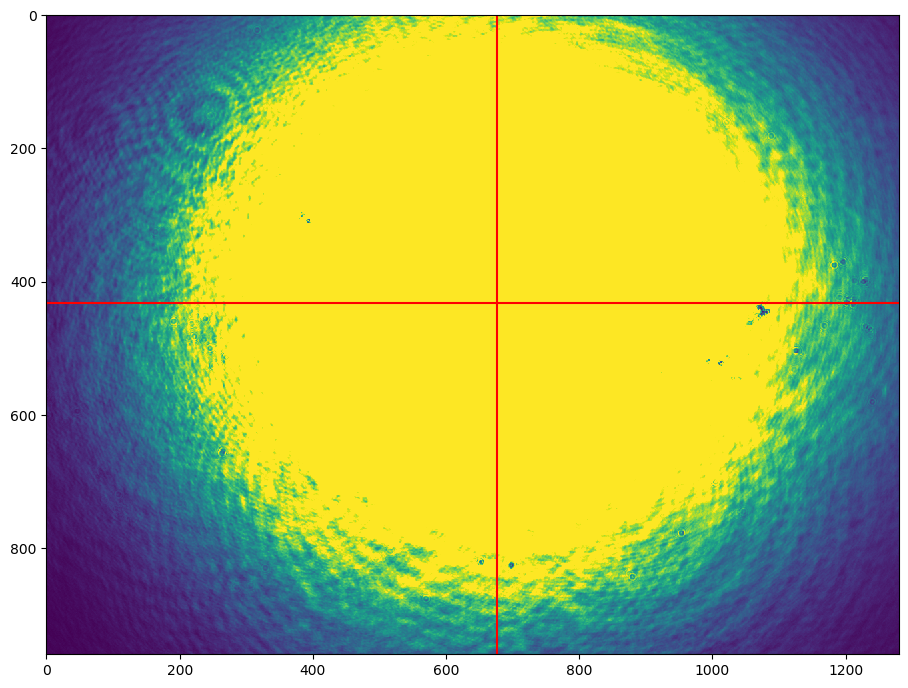

In [15]:
file = 'laser_position_1902019_0.npy'
data = np.load(os.path.join(base_dir, file))

mask = data>np.mean(data.reshape(data.size,1))#+np.std(data.reshape(data.size,1))
M = cv2.moments(mask*data)
cx = M['m10']/M['m00']
cy = M["m01"] / M["m00"]
print(cx, cy)

fig, ax = plt.subplots(1, figsize=(11,10), dpi=100)
fig.set()
ax.imshow(data.T)
ax.axhline(y=cx,color='red')
ax.axvline(x=cy,color='red')

In [63]:
circles

array([[[45., 55., 37.]]], dtype=float32)